In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re
import time
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN, TVAE
from sdv.constraints import Inequality, create_custom_constraint
from copy import deepcopy
import warnings
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('../data/data_50000.csv')

In [4]:
def is_valid_arithmetic_equality(column_names, data):
    is_equal = [data[column_names[0]] - data[column_names[1]] == data[column_names[2]]][0]
    return is_equal
    
arithmetic_equality_constraint = create_custom_constraint(is_valid_fn = is_valid_arithmetic_equality)

def is_valid_arithmetic_inequality(column_names, data):
    is_equal = [data[column_names[0]] >= data[column_names[1]] + column_names[2]][0]
    return is_equal

arithmetic_inequality_constraint = create_custom_constraint(is_valid_fn = is_valid_arithmetic_inequality)

def is_valid_inclusive(column_names, data):
    is_equal = []
    for index, row in data.iterrows():
        is_equal.append(str(int(row[column_names[0]]))[column_names[2]:column_names[2]+len(str(int(row[column_names[1]])))] == str(int(row[column_names[1]])))
    is_equal = pd.Series(i for i in is_equal)
    return is_equal

inclusive_constraint = create_custom_constraint(is_valid_fn = is_valid_inclusive)

class SD_generator():

    def __init__(self, data, inequality_threshold, arithmetic_equality_threshold, inclusive_threshold, 
                 inequality_dict=None, inequality_runtime=0,
                 arithmetic_equality_dict=None, arithmetic_equality_runtime=0, arithmetic_equality_flag=False,
                 arithmetic_inequality_dict=None, arithmetic_inequality_runtime=0,
                 inclusive_dict=None, inclusive_runtime=0, inclusive_flag=False,
                 constraints=None, models=None, temp_dict=None):
        
        self.data = data
        self.inequality_threshold = inequality_threshold
        self.arithmetic_equality_threshold = arithmetic_equality_threshold
        self.inclusive_threshold = inclusive_threshold
        self.inequality_dict = inequality_dict if inequality_dict is not None else {}
        self.inequality_runtime = inequality_runtime
        self.arithmetic_equality_dict = arithmetic_equality_dict if arithmetic_equality_dict is not None else {}
        self.arithmetic_equality_runtime = arithmetic_equality_runtime
        self.arithmetic_equality_flag = arithmetic_equality_flag
        self.arithmetic_inequality_dict = arithmetic_inequality_dict if arithmetic_inequality_dict is not None else {}
        self.arithmetic_inequality_runtime = arithmetic_inequality_runtime
        self.inclusive_dict = inclusive_dict if inclusive_dict is not None else {}
        self.inclusive_runtime = inclusive_runtime
        self.inclusive_flag = inclusive_flag
        self.constraints = constraints if constraints is not None else []
        self.models = models if models is not None else {}
        self.temp_dict = temp_dict if temp_dict is not None else {}
        
    def preprocess(self):
        
        st = time.time()
        
        ref_dt = pd.Timestamp('1900-01-01')

        str2date = lambda x: dt.strptime(x, "%Y-%m-%d") - ref_dt if x.replace(" ", "") else np.nan
        
        for col in self.data.columns:
            
            try:
                re.match('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}$', self.data[col][0])
                
                self.data[col] = self.data[col].apply(str2date)
                self.data[col] = (self.data[col] / np.timedelta64(1, 'D')).astype(float)
                
            except:
                pass
            
        self.data.dropna(axis=0, inplace=True)

        et = time.time()
        elapsed_time = et - st

    def detect_inequality(self):

        if bool(self.inequality_dict):
            return
        
        st = time.time()
        
        column_pairs = list(combinations(data.columns, 2))
        for column_pair in column_pairs:
            if self.data[column_pair[0]].dtypes in ['int', 'float'] and self.data[column_pair[1]].dtypes in ['int', 'float']:
                temp = self.data[[column_pair[0], column_pair[1]]].apply(lambda x: x[column_pair[0]] > x[column_pair[1]], axis=1)
                count_true = temp[temp == True].count()
                ratio = float(count_true) / len(temp)
                
                if ratio >= self.inequality_threshold:
                    if column_pair[0] in self.inequality_dict.keys():
                        self.inequality_dict[column_pair[0]].append(column_pair[1])
                    else:
                        self.inequality_dict[column_pair[0]] = []
                        self.inequality_dict[column_pair[0]].append(column_pair[1])
                
                elif (1 - ratio) >= self.inequality_threshold:
                    if column_pair[1] in self.inequality_dict.keys():
                        self.inequality_dict[column_pair[1]].append(column_pair[0])
                    else:
                        self.inequality_dict[column_pair[1]] = []
                        self.inequality_dict[column_pair[1]].append(column_pair[0])
        
        self.temp_dict = deepcopy(self.inequality_dict)
        
        for key in self.inequality_dict:
            for i in range(len(self.inequality_dict[key])):
                str_1 = self.inequality_dict[key][i]
                for j in range(i, len(self.inequality_dict[key])):
                    str_2 = self.inequality_dict[key][j]
                    if ((str_1 in self.inequality_dict) and (str_2 in self.inequality_dict[str_1])):
                        self.inequality_dict[key][j] = 'N/A' 
                    elif ((str_2 in self.inequality_dict) and (str_1 in self.inequality_dict[str_2])):
                        self.inequality_dict[key][i] = 'N/A'
        for key in self.inequality_dict:
            self.inequality_dict[key] = [i for i in self.inequality_dict[key] if i != 'N/A']
        
        et = time.time()
        self.inequality_runtime = et - st
        
        num = 0
        for key in self.inequality_dict:
            num += len(self.inequality_dict[key])
        
        return round(self.inequality_runtime, 4)

    def detect_arithmetic_equality(self):

        if bool(self.arithmetic_equality_dict):
            return
        
        st = time.time()
        
        for key in self.temp_dict:
            column_pairs = list(combinations(self.temp_dict[key], 2))
            for column_pair in column_pairs:
                temp = self.data[[key, column_pair[0], column_pair[1]]].apply(lambda x: x[key] == x[column_pair[0]] + x[column_pair[1]], axis=1)
                count_true = temp[temp == True].count()
                if float(count_true) / len(temp) >= self.arithmetic_equality_threshold:
                    if key in self.arithmetic_equality_dict.keys():
                        self.arithmetic_equality_dict[key].append([column_pair[0], column_pair[1]])
                    else:
                        self.arithmetic_equality_dict[key] = []
                        self.arithmetic_equality_dict[key].append([column_pair[0], column_pair[1]])
        
        et = time.time()
        self.arithmetic_equality_runtime = et - st
        
        num = 0
        for key in self.arithmetic_equality_dict:
            num += len(self.arithmetic_equality_dict[key])
        
        return round(self.arithmetic_equality_runtime, 4)
    
    def detect_arithmetic_inequality(self):

        if bool(self.arithmetic_inequality_dict):
            return
        
        st = time.time()
        
        for key in self.inequality_dict:
            for value in self.inequality_dict[key]:
                diff = []
                for index, row in self.data.iterrows():
                    diff.append(row[key] - row[value])
                    
                if key in self.arithmetic_inequality_dict.keys():
                    self.arithmetic_inequality_dict[key].append([value, min(diff)])
                else:
                    self.arithmetic_inequality_dict[key] = []
                    self.arithmetic_inequality_dict[key].append([value, min(diff)])
            
        et = time.time()
        self.arithmetic_inequality_runtime = et - st
        
        num = 0
        for key in self.arithmetic_inequality_dict:
            num += len(self.arithmetic_inequality_dict[key])
        
        return round(self.arithmetic_inequality_runtime, 4)
    
    def detect_inclusive(self):

        if bool(self.inclusive_dict):
            return
        
        st = time.time()
        
        data_length = len(self.data.index)
        
        column_pairs = list(combinations(self.data.columns, 2))
        
        for column_pair in column_pairs:
            ratio = 0
            
            if len(str(int(self.data.iloc[0][column_pair[1]]))) > len(str(int(self.data.iloc[0][column_pair[0]]))):
                temp = self.data[[column_pair[0], column_pair[1]]].apply(lambda x: str(x[column_pair[0]]) in str(x[column_pair[1]]), axis=1)
                count = temp[temp == True].count()
                ratio = float(count) / len(temp)
                key = column_pair[1]
                value = column_pair[0]
                index = str(self.data.loc[0][column_pair[1]]).find(str(self.data.loc[0][column_pair[0]]))
            
            elif len(str(int(self.data.iloc[0][column_pair[0]]))) > len(str(int(self.data.iloc[0][column_pair[1]]))):
                temp = self.data[[column_pair[0], column_pair[1]]].apply(lambda x: str(x[column_pair[1]]) in str(x[column_pair[0]]), axis=1)
                count = temp[temp == True].count()
                ratio = float(count) / len(temp)
                key = column_pair[0]
                value = column_pair[1]
                index = str(int(self.data.loc[0][column_pair[0]])).find(str(int(self.data.loc[0][column_pair[1]])))
                
            if ratio >= self.inclusive_threshold:
                
                if key in self.inclusive_dict.keys():
                        self.inclusive_dict[key].append([value, index])
                else:
                    self.inclusive_dict[key] = []
                    self.inclusive_dict[key].append([value, index])
            
        et = time.time()
        self.inclusive_runtime = et - st
        
        num = 0
        for key in self.inclusive_dict:
            num += len(self.inclusive_dict[key])
        
        return round(self.inclusive_runtime, 4)
    
    def create_constraints(self, inequality=False, 
                           arithmetic_equality=False, 
                           arithmetic_inequality=False, 
                           inclusive=False):
        
        if inequality:
            for key in self.inequality_dict:
                for value in self.inequality_dict[key]:
                    self.constraints.append(Inequality(low_column_name=value, high_column_name=key))
        
        if arithmetic_equality:
            self.arithmetic_equality_flag=True
                    
        if arithmetic_inequality:
            for key in self.arithmetic_inequality_dict:
                for value_list in self.arithmetic_inequality_dict[key]:
                    columns = [key, value_list[0], value_list[1]]
                    cons = arithmetic_inequality_constraint(column_names=columns)
                    self.constraints.append(cons)
        
        if inclusive:
            self.inclusive_flag=True
    
    def apply_model(self, model_name=None):
        
        st = time.time()
        
        # Check if the input of model name is missing
        if model_name == None:
            print("No input for model name!")
            return
        
        elif model_name == 'GaussianCopula':
            model = GaussianCopula(constraints=self.constraints)
            model.fit(self.data)
            self.models['GaussianCopula'] = model
            
            et = time.time()
            elapsed_time = et - st
            
        elif model_name == 'CTGAN':
            model = CTGAN(constraints=self.constraints)
            model.fit(self.data)
            self.models['CTGAN'] = model
            
            et = time.time()
            elapsed_time = et - st
            
        elif model_name == 'CopulaGAN':
            model = CopulaGAN(constraints=self.constraints)
            model.fit(self.data)
            self.models['CopulaGAN'] = model
            
            et = time.time()
            elapsed_time = et - st
            
        elif model_name == 'TVAE':
            model = TVAE(constraints=self.constraints)
            model.fit(self.data)
            self.models['TVAE'] = model
            
            et = time.time()
            elapsed_time = et - st
            
        else:
            print("Wrong model name!")
        
        return round(elapsed_time, 4)
            
    def generate(self, model_name=None, num_rows=0):

        if model_name == None:
            print("No input for model name!")
            return None
        elif (num_rows == 0) or (type(num_rows) != int):
            print("Number of rows has to be integer and greater than 0!")
            return None
        
        elif model_name not in ["GaussianCopula", "CTGAN", "CopulaGAN", "TVAE"]:
            print("Wrong model name!\nAccepted model name: GaussianCopula, CTAGAN, CopulaGAN and TVAE.")
            return None
        
        else:
            syn_data = self.models[model_name].sample(num_rows=num_rows)
            
            if self.arithmetic_equality_flag:
                for key in self.arithmetic_equality_dict:
                    syn_data[key] = syn_data[self.arithmetic_equality_dict[key][0][0]] + syn_data[self.arithmetic_equality_dict[key][0][1]]
            
            if self.inclusive_flag:
                for key in self.inclusive_dict:
                    for value_list in self.inclusive_dict[key]:
                        for index, row in syn_data.iterrows():
                            list_temp = list(str(int(row[key])))
                            list_temp[value_list[1] : value_list[1] + len(str(row[value_list[1]]))] = str(int(row[value_list[0]]))
                            syn_data.at[index, key] = int(''.join(list_temp))
                            
            return syn_data

In [5]:
size_list = [i for i in range(2500, 50001, 2500)]
data_list = [data.iloc[:i] for i in range(2500, 50001, 2500)]
inequality_list = []
arithmetic_equality_list = []
arithmetic_inequality_list = []
inclusive_list = []
GaussianCopula_list = []
CTGAN_list = []
CopulaGAN_list = []
TVAE_list = []

In [6]:
for i in range(len(size_list)):
    d = SD_generator(data_list[i], inequality_threshold=0.95, arithmetic_equality_threshold=0.95, inclusive_threshold=1.0)
    d.preprocess()
    inequality_list.append(d.detect_inequality())
    arithmetic_equality_list.append(d.detect_arithmetic_equality())
    arithmetic_inequality_list.append(d.detect_arithmetic_inequality())
    inclusive_list.append(d.detect_inclusive())
    
    d.create_constraints(inequality=True, arithmetic_equality=True, arithmetic_inequality=True, inclusive=True)
    
    GaussianCopula_list.append(d.apply_model("GaussianCopula"))
    CTGAN_list.append(d.apply_model("CTGAN"))
    CopulaGAN_list.append(d.apply_model("CopulaGAN"))
    TVAE_list.append(d.apply_model("TVAE"))

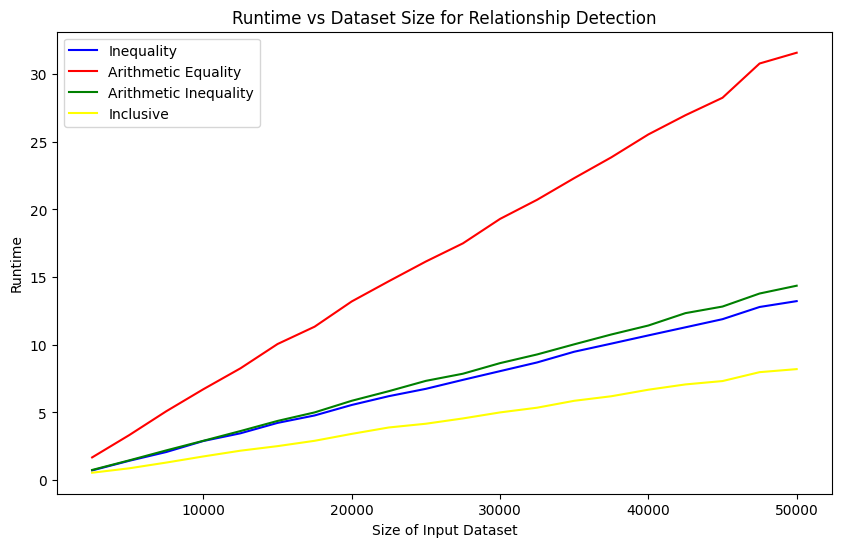

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(size_list, inequality_list, label='Inequality', color='blue')
plt.plot(size_list, arithmetic_equality_list, label='Arithmetic Equality', color='red')
plt.plot(size_list, arithmetic_inequality_list, label='Arithmetic Inequality', color='green')
plt.plot(size_list, inclusive_list, label='Inclusive', color='yellow')

plt.xlabel('Size of Input Dataset')
plt.ylabel('Runtime')
plt.title('Runtime vs Dataset Size for Relationship Detection')

plt.legend()
plt.show()

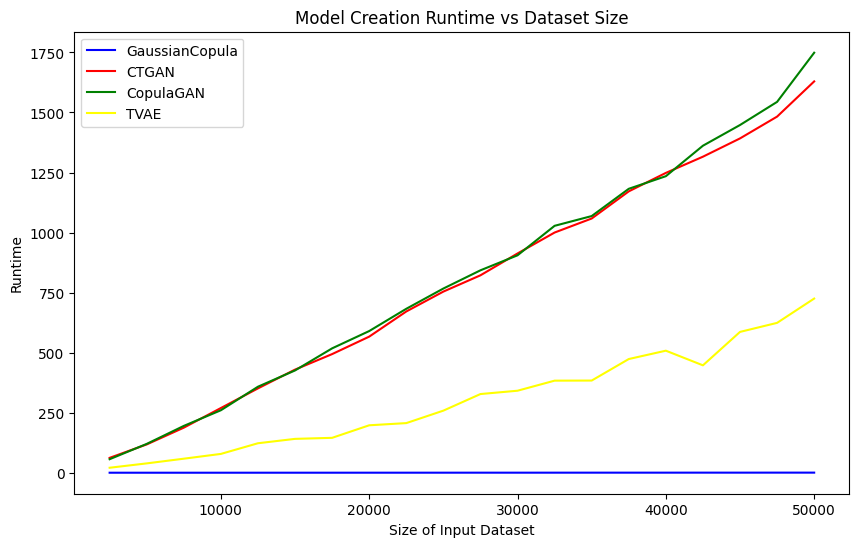

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(size_list, GaussianCopula_list, label='GaussianCopula', color='blue')
plt.plot(size_list, CTGAN_list, label='CTGAN', color='red')
plt.plot(size_list, CopulaGAN_list, label='CopulaGAN', color='green')
plt.plot(size_list, TVAE_list, label='TVAE', color='yellow')

plt.xlabel('Size of Input Dataset')
plt.ylabel('Runtime')
plt.title('Model Creation Runtime vs Dataset Size')

plt.legend()
plt.show()

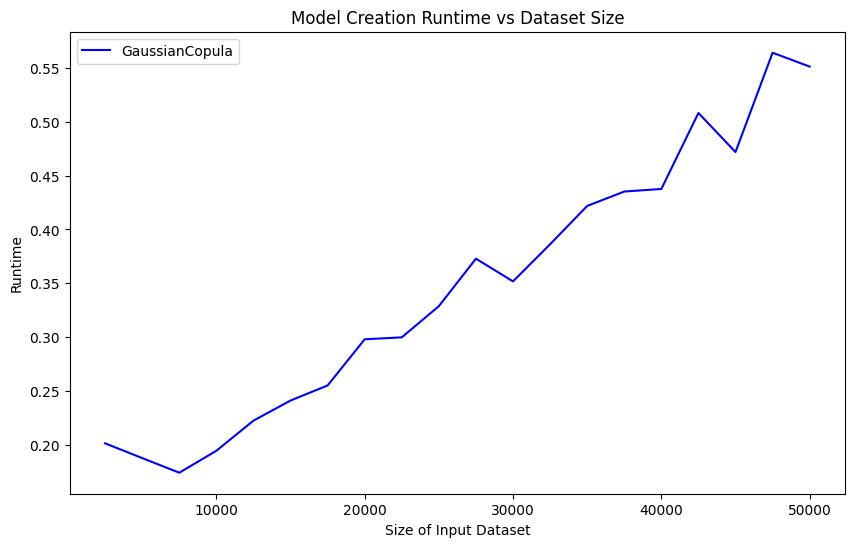

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(size_list, GaussianCopula_list, label='GaussianCopula', color='blue')
plt.xlabel('Size of Input Dataset')
plt.ylabel('Runtime')
plt.title('Model Creation Runtime vs Dataset Size')

plt.legend()
plt.show()